# Notebook for M3 assesment

This notebook as been created 

### Import of library

In [1]:
import grid2op
from grid2op.PlotGrid import PlotMatplot
from grid2op.Backend.PandaPowerBackend import PandaPowerBackend
from grid2op.Agent import DoNothingAgent
import numpy as np
from grid2op.Runner import Runner


C:\Users\rtschupp\AppData\Local\pypoetry\Cache\virtualenvs\pypowsybltest-3L0u-b9v-py3.10\lib\site-packages\grid2op\Backend\PandaPowerBackend.py:31: UserWarning: Numba cannot be loaded. You will gain possibly massive speed if installing it by 
	C:\Users\rtschupp\AppData\Local\pypoetry\Cache\virtualenvs\pypowsybltest-3L0u-b9v-py3.10\Scripts\python.exe -m pip install numba

  warnings.warn(


### Create a Grid2op environment

Here we load the rte_case14_realistic file, in the context of our project it should be france network as a whole for the final test.  

As you can see for the experience to be reproducible we can set a seed so the train/val/test sets are always the same. 

The backend would be changed to PypowsyblBackend.

The make function is highly customizable and a lot of parameters could be changed as well other classes.
For more details : https://grid2op.readthedocs.io/en/latest/makeenv.html#grid2op.MakeEnv.make 

In [2]:
env = grid2op.make("rte_case14_realistic", test=True,backend = PandaPowerBackend())  # i do a test, i set "Test=True" otherwise i don't specify anything
max_iter = 5  # we limit the number of iterations to reduce computation time. Put -1 if you don't want to limit it
env.seed(42)
obs = env.reset()

C:\Users\rtschupp\AppData\Local\pypoetry\Cache\virtualenvs\pypowsybltest-3L0u-b9v-py3.10\lib\site-packages\grid2op\MakeEnv\Make.py:393: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)


### We can then visualize our network and the data associated with each node

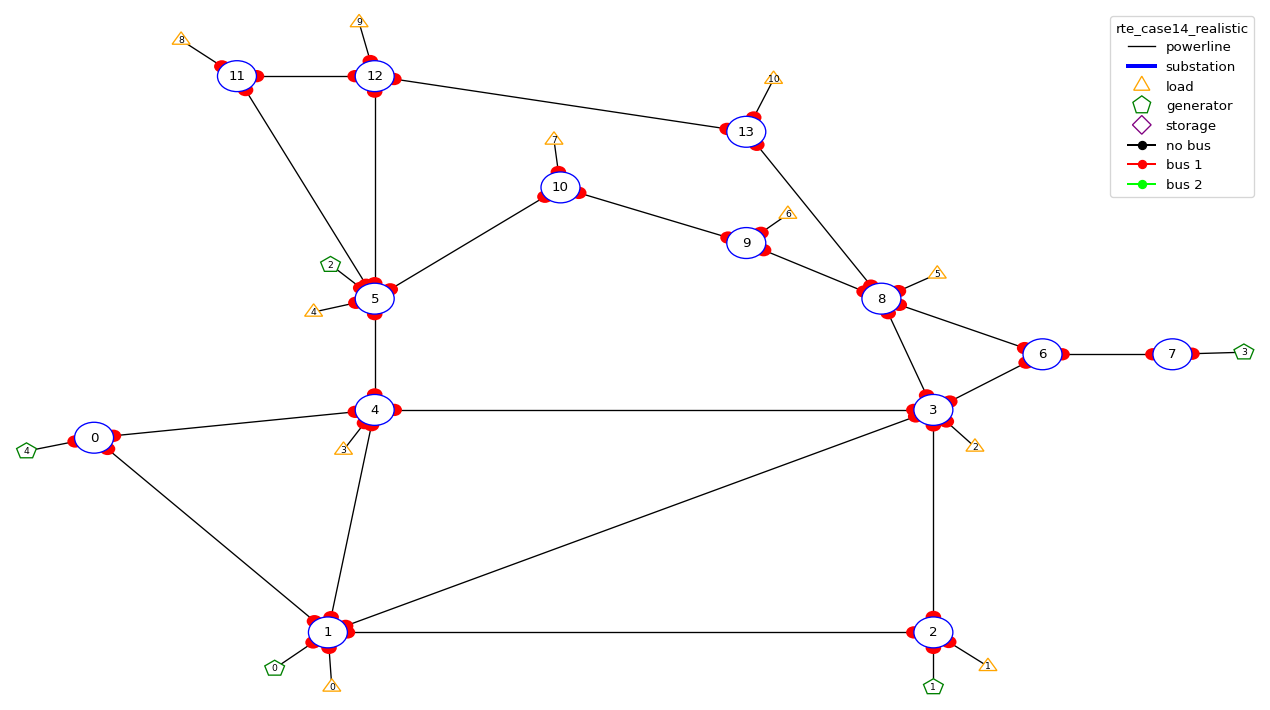

In [3]:
plot_helper = PlotMatplot(env.observation_space)
_ = plot_helper.plot_layout()

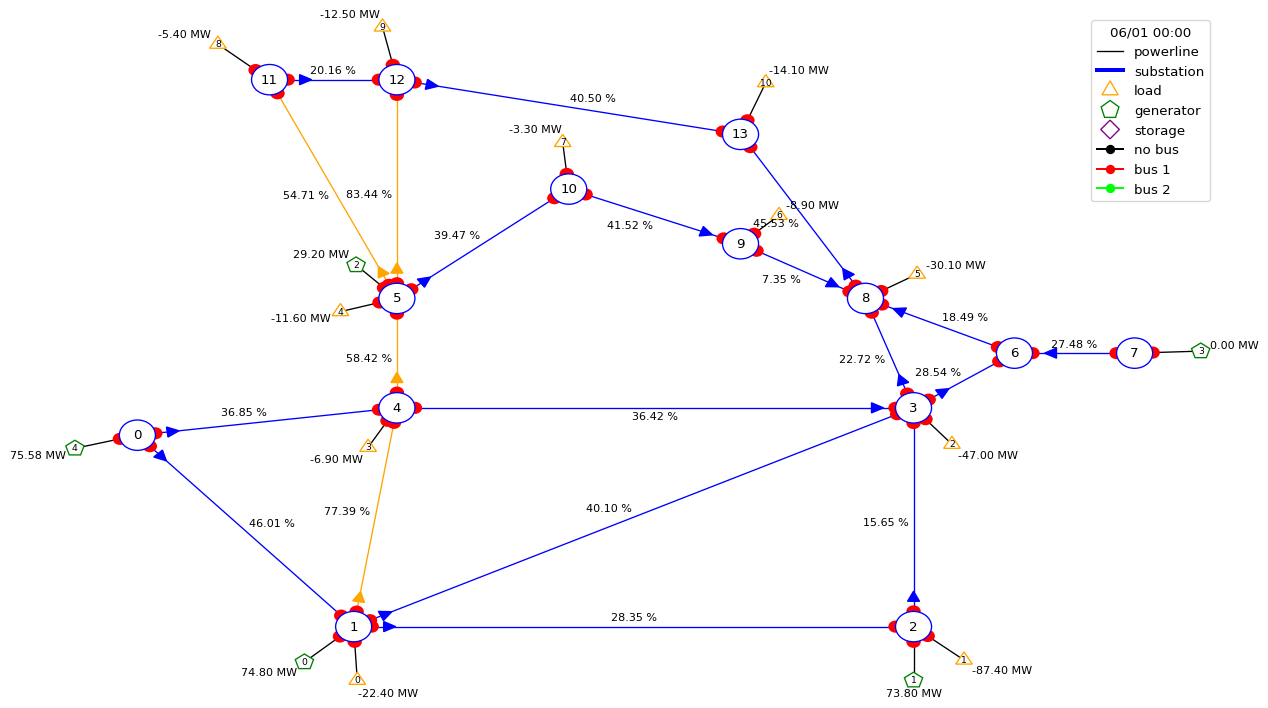

In [4]:
_ = plot_helper.plot_obs(obs)

### Different type of actions

<strong>There is five main types of actions possible</strong> :
* Injection actions
* Connection/Deconnection of a line
* Topological configuration at every substation  

     <em>If the rights parameters are given</em>
* Redispatching
* Curtailment



For more detail : https://grid2op.readthedocs.io/en/latest/action.html

### Create an agent

An agent would be the algorithm that is gonna take some actions (all the possible one written just a cell above), regarding some observation on the grid and the possible rewards.

In our case we chose the DoNothingAgent that is not gonna take any action at any time step of the simulation which is already pre-implemented. Otherwise it is possible to create one following Grid2op framework and rules.

For more informations : https://grid2op.readthedocs.io/en/latest/agent.html

This agent should be replaced with your personnal RL agent

In [5]:
my_agent = DoNothingAgent

### Train an agent

In a real application you should use a train/val/test split using 
```env.train_val_split_random()``` for example.  

It is also possible to use a complete gym environment.  
For more detail : https://grid2op.readthedocs.io/en/latest/gym.html 

In [6]:
runner = Runner(**env.get_params_for_runner(),
                agentClass=my_agent
               )
res = runner.run(nb_episode=1, max_iter=max_iter)

In [7]:
print("The results for DoNothing agent are:")
for _, chron_name, cum_reward, nb_time_step, max_ts in res:
    msg_tmp = "\tFor chronics with id {}\n".format(chron_name)
    msg_tmp += "\t\t - cumulative reward: {:.6f}\n".format(cum_reward)
    msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}".format(nb_time_step, max_ts)
    print(msg_tmp)

The results for DoNothing agent are:
	For chronics with id 000
		 - cumulative reward: 454.873596
		 - number of time steps completed: 5 / 5


In [ ]:
obs, reward, done, info = env.step(env.action_space())

In [ ]:
obs.minute_of_hour

In [ ]:
obs.

In [ ]:
info

In [ ]:
# example of training an agent
from l2rpn_baselines.DuelQSimple import train
from l2rpn_baselines.utils import NNParam, TrainingParam
import shutil

train_iter = 60  # again for time constraints. You should expect a real model to be trained on way more data


agent_name = "test_agent"
save_path = "saved_agent_DDDQN_BDA_{}".format(train_iter)
logs_dir="tf_logs_DDDQN"

# because this notebook is executed often, i clean the "save_path"
shutil.rmtree(save_path, ignore_errors=True)

# we then define the neural network we want to make (you may change this at will)
## 1. first we choose what "part" of the observation we want as input, 
## here for example only the generator and load information
## see https://grid2op.readthedocs.io/en/latest/observation.html#main-observation-attributes
## for the detailed about all the observation attributes you want to have
li_attr_obs_X = ["gen_p", "gen_v", "load_p", "load_q"]
# this automatically computes the size of the resulting vector
observation_size = NNParam.get_obs_size(env, li_attr_obs_X) 

## 2. then we define its architecture
sizes = [300, 300, 300]  # 3 hidden layers, of 300 units each, why not...
activs =  ["relu" for _ in sizes]  # all followed by relu activation, because... why not
## 4. you put it all on a dictionnary like that (specific to this baseline)
kwargs_archi = {'observation_size': observation_size,
                'sizes': sizes,
                'activs': activs,
                "list_attr_obs": li_attr_obs_X}

# you can also change the training parameters you are using
# more information at https://l2rpn-baselines.readthedocs.io/en/latest/utils.html#l2rpn_baselines.utils.TrainingParam
tp = TrainingParam()
tp.batch_size = 32  # for example...
tp.update_tensorboard_freq = int(train_iter / 10)
tp.save_model_each = int(train_iter / 3)
tp.min_observation = int(train_iter / 5)

# which actions i keep (on this small environment i CANNOT train an agent to perform the 66k actions)
kwargs_converters = {"all_actions": None,
                     "set_line_status": False,
                     "change_line_status": True,
                     "change_bus_vect": False,
                     "set_topo_vect": False
                     }
    
train(env,
      name=agent_name,
      iterations=train_iter,
      save_path=save_path,
      load_path=None, # put something else if you want to reload an agent instead of creating a new one
      logs_dir=logs_dir,
      kwargs_archi=kwargs_archi,
      training_param=tp,
      kwargs_converters=kwargs_converters,)
